# Philippe Chlenski - MATS application notebook

# Overview
This is a short exploration of a mechanistic interpretability topic as part of my SERI MATS application
View the Google doc here: https://docs.google.com/document/d/1fwaBQVlGPyOV8-elZfOkr905tYhuw5cQZ9KgXFq6y7A/edit?usp=sharing

## Research question
Look at the PCA of logits on the full dataset, or the PCA of a stack of flattened weights. If you plot a scatter plot of the first 2 components, the different phases of training are clearly visible. What's up with this?

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Python stuff
import einops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Neel stuff
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

# My modules
from src.utils import *  # empty at the moment
from src.plotting import *  # imshow, line, scatter

print("Done loading modules")

/home/phil/mambaforge/envs/mats/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/phil/mambaforge/envs/mats/lib/python3.11/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


Done loading modules


In [5]:
# Autodiff off
torch.set_grad_enabled(False)
print("Disabled autodiff")

Disabled autodiff


# Verify and visualize PCA of training phases

The first goal is to actually produce a PCA of logits and stacks of flattened weights so I can understand what the prompt means by "different phases of training are clearly visible." Based on context and my own hunches, I figure the modular addition models from the grokking paper would probably be a good place to start---at least because we already know that they grok. Let's get some plots going...

In [6]:
# What is the actual name of the modular addition transformer model? Let's find out:
# Documentation here: https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=1Z1d-y3LE8Y6TVqglA0UrGZS
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES

print(OFFICIAL_MODEL_NAMES)

['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'distilgpt2', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', 'stanford-crfm/alias-gpt2-small-x21', 'stanford-crfm/battlestar-gpt2-small-x49', 'stanford-crfm/caprica-gpt2-small-x81', 'stanford-crfm/darkmatter-gpt2-small-x343', 'stanford-crfm/expanse-gpt2-small-x777', 'stanford-crfm/arwen-gpt2-medium-x21', 'stanford-crfm/beren-gpt2-medium-x49', 'stanford-crfm/celebrimbor-gpt2-medium-x81', 'stanford-crfm/durin-gpt2-medium-x343', 'stanford-crfm/eowyn-gpt2-medium-x777', 'EleutherAI/pythia-14m', 'EleutherAI/pythia-31m', 'EleutherAI/pythia-70m', 'EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b', 'EleutherAI/pythia-1.4b', 'EleutherAI/pythia-2.8b', 'EleutherAI/pythia-6.9b', 'EleutherAI/pythia-12b',

OK, so it looks like I can't actually grab the modular addition model from here. Let's see if we can make do with some of the other checkpointed models

In [7]:
# Somewhat arbitrarily, let's pick the 1L512W model - it should be quite small and fast to load/run

model = HookedTransformer.from_pretrained("NeelNanda/GELU_1L512W_C4_Code", checkpoint_index=0)

Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer


odict_keys(['embed.W_E', 'pos_embed.W_pos', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_K', 'blocks.0.attn.W_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_Q', 'blocks.0.attn.b_K', 'blocks.0.attn.b_V', 'blocks.0.attn.b_O', 'blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'unembed.W_U', 'unembed.b_U'])


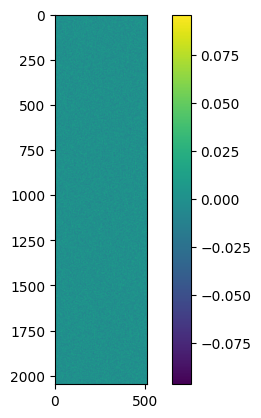

In [8]:
# Now let's take a look at its weights and logits

# Finding the weights
# What's in the state dict?
print(model.state_dict().keys())

# OK, it looks like we can get some mlp weights this way.
# For starters, let's take a look at the weights:
mlp_weights = model.blocks[0].mlp.W_out
imshow(mlp_weights)
plt.colorbar()
plt.show()

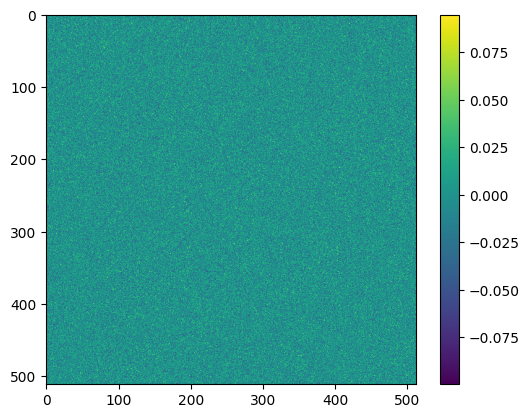

In [11]:
# Attention case:

att_weights = model.blocks[0].attn.W_O
imshow(att_weights.reshape(512, 512))
plt.colorbar()
plt.show()

In [12]:
# Let's try to aggregate some weights across checkpoints
# I'm not sure how many checkpoint indices there are here, so I'm just gonna try 200 and see what happens...

mlp_weights_dict = {}
att_weights_dict = {}

for checkpoint_idx in range(200):  # 163 derived from other trials
    try:
        model = HookedTransformer.from_pretrained("NeelNanda/GELU_1L512W_C4_Code", checkpoint_index=checkpoint_idx)
        mlp_weights_dict[checkpoint_idx] = model.blocks[0].mlp.W_out
        att_weights_dict[checkpoint_idx] = model.blocks[0].attn.W_O
    except:
        break

Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer

IndexError: list index out of range

In [13]:
print(checkpoint_idx)  # 163 - this tells us how many checkpoints there are

163


In [14]:
# Save weights just in case
import pickle

with open("data/mlp_weights_dict.pkl", "wb") as f:
    pickle.dump(mlp_weights_dict, f)

with open("data/att_weights_dict.pkl", "wb") as f:
    pickle.dump(att_weights_dict, f)

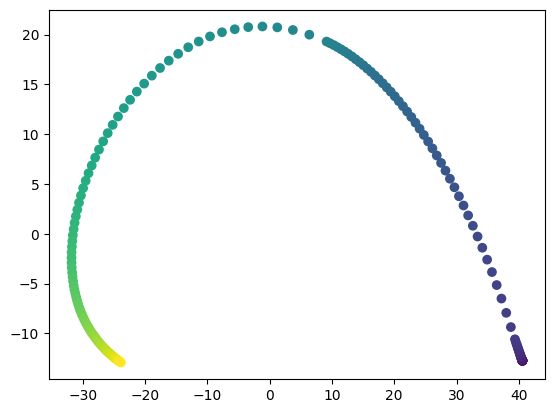

In [16]:
# Basic PCA on the MLP weights:
from sklearn.decomposition import PCA

# Plot PCA for flattened weights
all_flattened_mlp_weights = np.array([mlp_weights_dict[i].flatten() for i in range(163)])
all_flattened_mlp_weights_pca = PCA(n_components=2).fit_transform(all_flattened_mlp_weights)

plt.scatter(
    all_flattened_mlp_weights_pca[:, 0],
    all_flattened_mlp_weights_pca[:, 1],
    c=np.arange(len(all_flattened_mlp_weights_pca)),
)

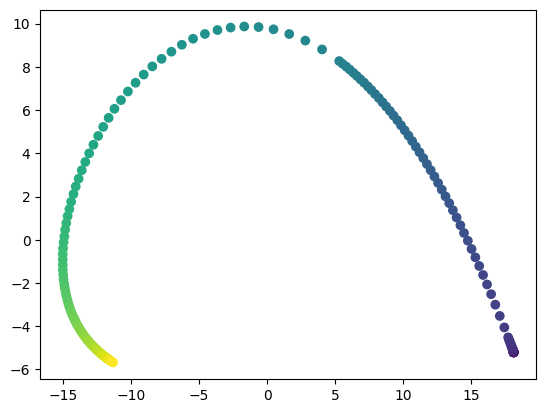

In [24]:
# Same thing for attention

# Plot PCA for flattened weights
all_flattened_att_weights = np.array([att_weights_dict[i].flatten() for i in range(163)])
all_flattened_att_weights_pca = PCA(n_components=2).fit_transform(all_flattened_att_weights)

plt.scatter(
    all_flattened_att_weights_pca[:, 0],
    all_flattened_att_weights_pca[:, 1],
    c=np.arange(len(all_flattened_att_weights_pca)),
)

# Same thing but for modular addition task

Using the notebook here: https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=P9C8QVqyy0QN

I decided to download the modular addition checkpoints found in https://drive.google.com/file/d/12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy/view?usp=sharing

I downloaded them into `data/grokking_addition_full_run.pth`

In [2]:
print("Hello world")
import torch

full_run_data = torch.load("data/grokking_addition_full_run.pth")
# print(full_run_data.keys())
# print(full_run_data['config'])

Hello world


/home/phil/mambaforge/envs/mats/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.